In [ ]:
import random
import shutil
import pathlib
import os, glob
import itertools
import cv2 as cv
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from PIL import Image, ImageOps
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

ModuleNotFoundError: No module named 'deepface'

In [ ]:
def preprocessing_function(image):
    return tf.keras.applications.xception.preprocess_input(image)
    
def load_image_data_generator(
                            train_path: str = 'data/emotion/train',
                            test_path: str = 'data/emotion/test',
                            ):
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocessing_function)
    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocessing_function)
    train_generator = train_datagen.flow_from_directory(
                                                        train_path,
                                                        batch_size=128,
                                                        target_size=(72, 72),
                                                        class_mode='categorical'
                                                        )   

    test_generator = test_datagen.flow_from_directory(
                                                    test_path,
                                                    batch_size=128,
                                                    target_size=(72, 72),
                                                    class_mode='categorical'
                                                    )   
    return train_generator, test_generator

In [7]:
train_generator, test_generator = load_image_data_generator()

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [8]:
def build_model():
    mobilenet_base = tf.keras.applications.Xception(
                                                    input_shape=(72, 72, 3),
                                                    include_top=False,
                                                    weights='imagenet'
                                                    )       
    inputs = tf.keras.Input(shape=(72, 72, 3))
    x = mobilenet_base(inputs, training=True)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(7, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)

    model.compile(
                optimizer=tf.keras.optimizers.Adam(),
                loss='categorical_crossentropy',
                metrics=[
                        tf.keras.metrics.CategoricalAccuracy(),
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),
                        tf.keras.metrics.AUC()
                        ]
                )
    return model

In [9]:
model_emotion = build_model()
model_emotion.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 72, 72, 3)]       0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 7)                 14343     
                                                                 
Total params: 20,875,823
Trainable params: 20,821,295
Non-trainable params: 54,528
____________________________________________

In [10]:
history_emotion = model_emotion.fit(
                                    train_generator, epochs=25,
                                    validation_data=test_generator
                                    )       

Epoch 1/25
225/225 [==============================] - 225s 950ms/step - loss: 1.2392 - categorical_accuracy: 0.5284 - precision: 0.7350 - recall: 0.3329 - auc: 0.8675 - val_loss: 0.9275 - val_categorical_accuracy: 0.6581 - val_precision: 0.7992 - val_recall: 0.4940 - val_auc: 0.9295
Epoch 2/25
225/225 [==============================] - 36s 160ms/step - loss: 0.9503 - categorical_accuracy: 0.6458 - precision: 0.7671 - recall: 0.5131 - auc: 0.9242 - val_loss: 0.7570 - val_categorical_accuracy: 0.7265 - val_precision: 0.8386 - val_recall: 0.6052 - val_auc: 0.9533
Epoch 3/25
225/225 [==============================] - 36s 159ms/step - loss: 0.7618 - categorical_accuracy: 0.7195 - precision: 0.8003 - recall: 0.6347 - auc: 0.9510 - val_loss: 0.5732 - val_categorical_accuracy: 0.8034 - val_precision: 0.8856 - val_recall: 0.7065 - val_auc: 0.9743
Epoch 4/25
225/225 [==============================] - 36s 159ms/step - loss: 0.6016 - categorical_accuracy: 0.7833 - precision: 0.8374 - recall: 0.728

In [11]:
model_emotion.save('artifacts/emotion_model.h5')

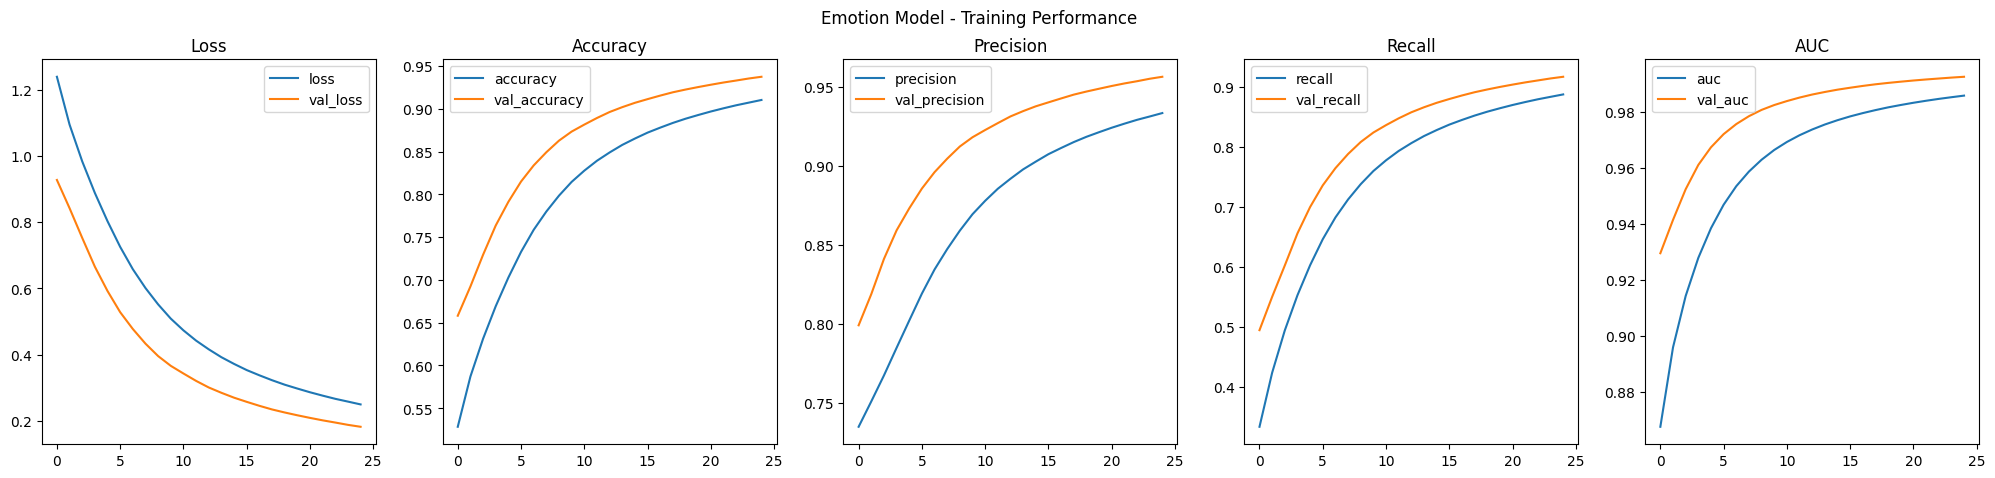

In [12]:
# Plot History
history_emotion.history['loss'] = np.cumsum(history_emotion.history['loss']) / np.arange(1, len(history_emotion.history['loss']) + 1)
history_emotion.history['val_loss'] = np.cumsum(history_emotion.history['val_loss']) / np.arange(1, len(history_emotion.history['val_loss']) + 1)

history_emotion.history['categorical_accuracy'] = np.cumsum(history_emotion.history['categorical_accuracy']) / np.arange(1, len(history_emotion.history['categorical_accuracy']) + 1)
history_emotion.history['val_categorical_accuracy'] = np.cumsum(history_emotion.history['val_categorical_accuracy']) / np.arange(1, len(history_emotion.history['val_categorical_accuracy']) + 1)

history_emotion.history['precision'] = np.cumsum(history_emotion.history['precision']) / np.arange(1, len(history_emotion.history['precision']) + 1)
history_emotion.history['val_precision'] = np.cumsum(history_emotion.history['val_precision']) / np.arange(1, len(history_emotion.history['val_precision']) + 1)

history_emotion.history['recall'] = np.cumsum(history_emotion.history['recall']) / np.arange(1, len(history_emotion.history['recall']) + 1)
history_emotion.history['val_recall'] = np.cumsum(history_emotion.history['val_recall']) / np.arange(1, len(history_emotion.history['val_recall']) + 1)

history_emotion.history['auc'] = np.cumsum(history_emotion.history['auc']) / np.arange(1, len(history_emotion.history['auc']) + 1)
history_emotion.history['val_auc'] = np.cumsum(history_emotion.history['val_auc']) / np.arange(1, len(history_emotion.history['val_auc']) + 1)

plt.figure(figsize=(25, 5))
plt.subplot(1, 5, 1)
plt.plot(history_emotion.history['loss'], label='loss')
plt.plot(history_emotion.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 5, 2)
plt.plot(history_emotion.history['categorical_accuracy'], label='accuracy')
plt.plot(history_emotion.history['val_categorical_accuracy'], label='val_accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 5, 3)
plt.plot(history_emotion.history['precision'], label='precision')
plt.plot(history_emotion.history['val_precision'], label='val_precision')
plt.legend()
plt.title('Precision')

plt.subplot(1, 5, 4)
plt.plot(history_emotion.history['recall'], label='recall')
plt.plot(history_emotion.history['val_recall'], label='val_recall')
plt.legend()
plt.title('Recall')

plt.subplot(1, 5, 5)
plt.plot(history_emotion.history['auc'], label='auc')
plt.plot(history_emotion.history['val_auc'], label='val_auc')
plt.legend()
plt.title('AUC')

plt.suptitle('Emotion Model - Training Performance')
plt.show()

### inference

In [1]:
import os
import datetime
import cv2 as cv
import numpy as np
import pandas as pd
import tensorflow as tf
from deepface import DeepFace
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
model_emotion = tf.keras.models.load_model('artifacts/emotion_model.h5')
model_emotion.compile(
                    optimizer=tf.keras.optimizers.Adam(),
                    loss='categorical_crossentropy',
                    metrics=[
                            tf.keras.metrics.CategoricalAccuracy(),
                            tf.keras.metrics.Precision(),
                            tf.keras.metrics.Recall(),
                            tf.keras.metrics.AUC()
                            ]
                    )

In [12]:
def inference_simple(img_path):
    objs = DeepFace.analyze(
                            img_path = img_path, 
                            actions = ['emotion'],
                            enforce_detection=False
                            )
    if len(objs) > 0:
        emotion_dict = objs[0]['emotion']
        emotion = max(emotion_dict, key=emotion_dict.get)
        return emotion
    else:
        return None

In [13]:
img_path = "data/emotion/train/fearful/im0.png"
inference_simple(img_path)

'fear'